# Customer Relationship Management (CRM)

## Customer Lifetime Value Prediction
___

**Business Problem: There is an e-commerce company and this company want to calculate Customer Liftetime Value Prediction for their future strategy.** 
___

__Variables__

Invoice: Unique number for each invoice. If invoice number starts with 'C', it's mean this invoice cancelled.

StockCode: Unique number for each product.

Description: Prooduct name.

Quantity: Indicates how many units of the product were sold.

InvoiceDate: Invoice date.

Price: Product price for each units. (Sterling)

CustumerID: Unique ID for each customer.

Country: Customer country.

**Import Libraries**

In [108]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.float_format', lambda x: '%.3f' %x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

**Outlier Threshold Functions**

In [2]:
def outlier_threshold(dataframe, variable):
    
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile = quartile3 - quartile1
    up_limit = quartile3 + 1.5*interquantile
    low_limit = quartile1 - 1.5*interquantile
    
    return low_limit, up_limit


def replace_with_outlier(dataframe, variable):
    
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit    

**Read Excel File**

In [3]:
df_ = pd.read_excel('crm_analytics/datasets/online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [4]:
df = df_.copy()

## Understanding Data

**First 15 rows**

In [5]:
df.head(15)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.650,17850.000,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.250,17850.000,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.850,17850.000,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.850,17850.000,United Kingdom
9,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.250,13047.000,United Kingdom


**Check units and columns**

In [6]:
df.shape

(541910, 8)

**Check null units for each columns**

In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

**Check the unique values for each variables**

In [8]:
df.nunique()

Invoice        25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
Price           1630
Customer ID     4372
Country           38
dtype: int64

## Data Preparation

**Remove null units from dataframe**

In [9]:
df.shape

(541910, 8)

In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(406830, 8)

**Deleting cancalled invoice**

In [12]:
df = df[~df['Invoice'].str.contains('C', na=False)]

In [13]:
df.shape

(397925, 8)

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.000,13.022,180.420,1.000,2.000,6.000,12.000,80995.000
Price,397925.000,3.116,22.097,0.000,1.250,1.950,3.750,8142.750
Customer ID,397925.000,15294.309,1713.173,12346.000,13969.000,15159.000,16795.000,18287.000


In [15]:
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.000,12.988,179.332,1.000,2.000,6.000,12.000,80995.000
Price,397885.000,3.117,22.098,0.001,1.250,1.950,3.750,8142.750
Customer ID,397885.000,15294.417,1713.144,12346.000,13969.000,15159.000,16795.000,18287.000


**Deleting outlier values**

In [17]:
replace_with_outlier(df, 'Quantity')

In [18]:
replace_with_outlier(df, 'Price')

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.000,11.831,25.523,1.000,2.000,6.000,12.000,298.500
Price,397885.000,2.893,3.227,0.001,1.250,1.950,3.750,37.060
Customer ID,397885.000,15294.417,1713.144,12346.000,13969.000,15159.000,16795.000,18287.000


**Add 'TotalPrice' to dataframe.**

TotalPrice = Quantity x UnitPrice

In [20]:
df['TotalPrice'] = df['Quantity'] * df['Price']

In [21]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.000,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365,71053,WHITE METAL LANTERN,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.000,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.000,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340


**Get analyze date**

Analyze (Today) date = Max date + 2 days

In [22]:
max_day = df['InvoiceDate'].max()
max_day

Timestamp('2011-12-09 12:50:00')

In [23]:
today_date = dt.datetime(max_day.year, max_day.month, max_day.day+2)
today_date

datetime.datetime(2011, 12, 11, 0, 0)

## Preparation of Lifetime Data Structure

Recency: Last purchase - First purchase (weekly for each customer)

T: Analyze date - First purchase (weekly for each customer)

Frequency: Total number of repeat purchases (frequency > 1)

Monetary: Average value for each purchase

In [49]:
cltv_df = df.groupby('Customer ID').agg({
    'InvoiceDate': [lambda x: (x.max() - x.min()).days, lambda x: (today_date - x.min()).days],
    'Invoice': lambda x: x.nunique(),
    'TotalPrice': lambda x: x.sum()
})

In [50]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.000             0        326        1    310.440
12347.000           365        368        7   4310.000
12348.000           282        359        4   1770.780
12349.000             0         19        1   1491.720
12350.000             0        311        1    331.460

**Edit columns name**

In [51]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [52]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.000,0,326,1,310.440
12347.000,365,368,7,4310.000
12348.000,282,359,4,1770.780
12349.000,0,19,1,1491.720
12350.000,0,311,1,331.460


**Convert the recency and T columns to weekly and monetary to average** 

In [53]:
cltv_df['monetary'] = cltv_df['monetary'] / cltv_df['frequency']

In [54]:
cltv_df['recency'] = cltv_df['recency'] / 7
cltv_df['T'] = cltv_df['T'] / 7

In [55]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [56]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.000,52.143,52.571,7,615.714
12348.000,40.286,51.286,4,442.695
12352.000,37.143,42.429,8,219.543
12356.000,43.143,46.571,3,937.143
12358.000,21.286,21.571,2,575.210


In [57]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.000,28.415,16.267,0.000,14.000,29.571,42.714,53.286
T,2845.000,36.969,14.713,0.429,27.429,40.429,51.286,53.429
frequency,2845.000,5.989,9.044,2.000,2.000,4.000,6.000,209.000
monetary,2845.000,372.174,349.301,3.450,191.073,300.487,436.870,5724.303


## Establishment of BG/NBD Model

In [58]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [59]:
bgf.fit(
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

## Some Querries

**Who are the best ten customers that we expect the most to purchase in a week?**

In [60]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
12748.000   3.250
14911.000   3.126
17841.000   1.940
13089.000   1.537
14606.000   1.464
15311.000   1.434
12971.000   1.357
14646.000   1.206
13408.000   0.986
18102.000   0.969
dtype: float64

**Creating a new column called expected_purch_one_week and assign model predictions on cltv_df**

In [61]:
cltv_df['expected_purch_one_week'] = bgf.conditional_expected_number_of_purchases_up_to_time(1,
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T'])

In [62]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purch_one_week
Customer ID,,,,,
12347.000,52.143,52.571,7,615.714,0.141
12348.000,40.286,51.286,4,442.695,0.092
12352.000,37.143,42.429,8,219.543,0.182
12356.000,43.143,46.571,3,937.143,0.086
12358.000,21.286,21.571,2,575.210,0.122


**Who are the best ten customers that we expect the most to purchase in a month?**

In [63]:
bgf.conditional_expected_number_of_purchases_up_to_time(4,
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
12748.000   12.963
14911.000   12.472
17841.000    7.740
13089.000    6.133
14606.000    5.840
15311.000    5.719
12971.000    5.413
14646.000    4.812
13408.000    3.934
18102.000    3.864
dtype: float64

**Creating a new column called expected_purch_one_month and assign model predictions on cltv_df**

In [68]:
cltv_df['expected_purch_one_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(4,
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T'])

In [69]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purch_one_week,expected_purch_one_month
Customer ID,,,,,,
12347.000,52.143,52.571,7,615.714,0.141,0.564
12348.000,40.286,51.286,4,442.695,0.092,0.367
12352.000,37.143,42.429,8,219.543,0.182,0.727
12356.000,43.143,46.571,3,937.143,0.086,0.344
12358.000,21.286,21.571,2,575.210,0.122,0.486


**Creating a new column called expected_purch_three_month and assign model predictions on cltv_df**

In [70]:
cltv_df['expected_purch_three_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(12,
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T'])

In [72]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purch_one_week,expected_purch_one_month,expected_purch_three_month
Customer ID,,,,,,,
12347.000,52.143,52.571,7,615.714,0.141,0.564,1.678
12348.000,40.286,51.286,4,442.695,0.092,0.367,1.092
12352.000,37.143,42.429,8,219.543,0.182,0.727,2.163
12356.000,43.143,46.571,3,937.143,0.086,0.344,1.022
12358.000,21.286,21.571,2,575.210,0.122,0.486,1.439


## Evaluate model prediction

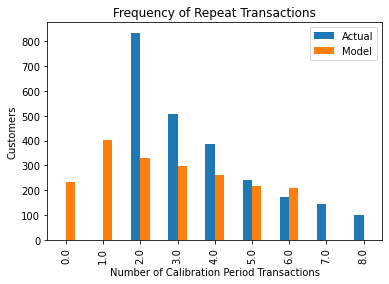

In [73]:
plot_period_transactions(bgf)
plt.show()

## Establishing of Gamma-Gamma Model

In [74]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [75]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [76]:
ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary']).head()

Customer ID
12347.000   631.912
12348.000   463.746
12352.000   224.887
12356.000   995.999
12358.000   631.902
dtype: float64

In [77]:
cltv_df['expected_average_profit'] = ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary'])

In [78]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purch_one_week,expected_purch_one_month,expected_purch_three_month,expected_average_profit
Customer ID,,,,,,,,
12347.000,52.143,52.571,7,615.714,0.141,0.564,1.678,631.912
12348.000,40.286,51.286,4,442.695,0.092,0.367,1.092,463.746
12352.000,37.143,42.429,8,219.543,0.182,0.727,2.163,224.887
12356.000,43.143,46.571,3,937.143,0.086,0.344,1.022,995.999
12358.000,21.286,21.571,2,575.210,0.122,0.486,1.439,631.902


## Calculation of CLTV Prediction with BG-NBD and Gamma-Gamma Model

In [97]:
cltv = ggf.customer_lifetime_value(bgf,
                                  cltv_df['frequency'],
                                  cltv_df['recency'],
                                  cltv_df['T'],
                                  cltv_df['monetary'],
                                  time=3, # for 3 month
                                  freq='W', # weekly
                                  discount_rate=0.01)

In [98]:
cltv.head()

Customer ID
12347.000   1128.448
12348.000    538.809
12352.000    517.500
12356.000   1083.090
12358.000    966.673
Name: clv, dtype: float64

In [102]:
cltv.reset_index()

,Customer ID,clv
0,12347.000,1128.448
1,12348.000,538.809
2,12352.000,517.500
3,12356.000,1083.090
4,12358.000,966.673
...,...,...
2840,18272.000,1146.206
2841,18273.000,96.565
2842,18282.000,168.595
2843,18283.000,505.512


In [103]:
cltv_final = cltv_df.merge(cltv, on='Customer ID', how='left')

In [105]:
cltv_final.sort_values('clv', ascending=False)

,recency,T,frequency,monetary,expected_purch_one_week,expected_purch_one_month,expected_purch_three_month,expected_average_profit,clv
Customer ID,,,,,,,,,
14646.000,50.429,50.714,73,3646.076,1.206,4.812,14.334,3654.815,55741.084
18102.000,52.286,52.571,60,3859.739,0.969,3.864,11.511,3870.997,47412.580
14096.000,13.857,14.571,17,3163.588,0.729,2.896,8.553,3196.436,29061.661
12415.000,44.714,48.286,21,5724.303,0.380,1.514,4.508,5772.178,27685.100
14911.000,53.143,53.429,201,691.710,3.126,12.472,37.164,692.326,27377.412
...,...,...,...,...,...,...,...,...,...
17912.000,7.714,52.143,5,62.202,0.001,0.004,0.013,65.211,0.905
15332.000,0.429,52.857,4,415.265,0.000,0.001,0.002,435.072,0.701
16725.000,9.857,53.143,7,111.574,0.000,0.002,0.005,114.957,0.550


## Creating Customer Segments

In [106]:
cltv_final['segments'] = pd.qcut(cltv_final['clv'], 4, labels=['D', 'C', 'B', 'A'])

In [109]:
cltv_final.groupby('segments').agg(['count', 'mean', 'sum'])

recency                      T                  frequency              monetary                    expected_purch_one_week               expected_purch_one_month               expected_purch_three_month                expected_average_profit                      clv                     
           count   mean       sum count   mean       sum     count   mean   sum    count    mean        sum                   count  mean     sum                    count  mean     sum                      count  mean      sum                   count    mean        sum count     mean         sum
segments                                                                                                                                                                                                                                                                                                
D            712 22.074 15716.571   712 40.465 28811.000       712  3.065  2182      712 183.963 130981.712                     712 0.071  50.590                      712 0.283 201.477                        712 0.840  598.091                     712 199.438 141999.665   712  143.297  102027.490
C            711 30.670 21806.143   711 38.111 27097.000       711  4.096  2912      711 271.695 193174.985                     711 0.121  85.731                      711 0.480 341.394                        711 1.425 1013.218                     711 289.986 206179.746   711  380.792  270743.007
B            711 29.515 20985.000   711 34.812 24751.143       711  5.442  3869      711 373.443 265517.631                     711 0.162 115.507                      711 0.647 459.693                        711 1.917 1362.659                     711 393.894 280058.943   711  688.265  489356.392
A            711 31.411 22333.143   711 34.484 24518.143       711 11.359  8076      711 659.859 469159.458                     711 0.274 194.499                      711 1.089 774.330                        711 3.231 2297.145                     711 685.900 487674.724   711 2222.360 1580097.928

## Functionalization All Steps

In [116]:
def create_clv_prediction(dataframe, month=3, csv=False):
    
    # Data Preparation
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe['Invoice'].str.contains('C', na=False)]
    dataframe = dataframe[dataframe['Quantity'] > 0]
    dataframe = dataframe[dataframe['Price'] > 0]
    replace_with_outlier(dataframe, 'Quantity')
    replace_with_outlier(dataframe, 'Price')
    dataframe['TotalPrice'] = dataframe['Quantity'] * dataframe['Price']
    max_day = dataframe['InvoiceDate'].max()
    today_date = dt.datetime(max_day.year, max_day.month, max_day.day+2)
    
    # Preparation of lifetime Data Structure
    cltv_df = dataframe.groupby('Customer ID').agg({
    'InvoiceDate': [lambda x: (x.max() - x.min()).days, lambda x: (today_date - x.min()).days],
    'Invoice': lambda x: x.nunique(),
    'TotalPrice': lambda x: x.sum()
    })
    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df['monetary'] = cltv_df['monetary'] / cltv_df['frequency']
    cltv_df['recency'] = cltv_df['recency'] / 7
    cltv_df['T'] = cltv_df['T'] / 7
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    
    # BG-NBD Model
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T'])
    
    cltv_df['expected_purch_1_week'] = bgf.conditional_expected_number_of_purchases_up_to_time(1,
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T'])
    
    cltv_df['expected_purch_1_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(4,
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T'])
    
    cltv_df['expected_purch_three_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(12,
    cltv_df['frequency'],
    cltv_df['recency'],
    cltv_df['T'])
    
    # Gamma-Gamma Model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df['expected_average_profit'] = ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary'])
    
    # Calculation of CLTV Prediction with BG-NBD and Gamma-Gamma Model
    cltv = ggf.customer_lifetime_value(bgf,
                                  cltv_df['frequency'],
                                  cltv_df['recency'],
                                  cltv_df['T'],
                                  cltv_df['monetary'],
                                  time=month, # month
                                  freq='W', # weekly
                                  discount_rate=0.01)
    
    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on='Customer ID', how='left')
    
    # Creating Customer Segments
    cltv_final['segments'] = pd.qcut(cltv_final['clv'], 4, labels=['D', 'C', 'B', 'A'])
    cltv_final.groupby('segments').agg(['count', 'mean', 'sum'])
    
    if csv:
        cltv_final.to_csv('cltv_prediction.csv')
    
    return cltv_final
    

In [117]:
test_df = df_.copy()

In [118]:
create_clv_prediction(test_df, month=3, csv=True)

,Customer ID,recency,T,frequency,monetary,expected_purch_1_week,expected_purch_1_month,expected_purch_three_month,expected_average_profit,clv,segments
0,12347.000,52.143,52.571,7,615.714,0.141,0.564,1.678,631.912,1128.448,A
1,12348.000,40.286,51.286,4,442.695,0.092,0.367,1.092,463.746,538.809,B
2,12352.000,37.143,42.429,8,219.543,0.182,0.727,2.163,224.887,517.500,B
3,12356.000,43.143,46.571,3,937.143,0.086,0.344,1.022,995.999,1083.090,A
4,12358.000,21.286,21.571,2,575.210,0.122,0.486,1.439,631.902,966.673,A
...,...,...,...,...,...,...,...,...,...,...,...
2840,18272.000,34.857,35.286,6,513.097,0.172,0.686,2.037,529.018,1146.206,A
2841,18273.000,36.429,36.857,3,68.000,0.104,0.416,1.235,73.494,96.565,D
2842,18282.000,16.857,18.143,2,89.025,0.136,0.539,1.593,99.525,168.595,D
2843,18283.000,47.571,48.286,16,130.930,0.302,1.203,3.583,132.601,505.512,C
